In [108]:
import glob
import pandas as pd
import json

projects = ["djanjo", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    filenames = glob.glob(f"../output/pytlint/{project}/*.json")
    for filename in filenames:
        with open(filename) as json_data:
            data = json.load(json_data)
            df = pd.json_normalize(data)
            df['project'] = project
            dfs.append(df)




In [109]:
df_py = pd.concat(dfs, ignore_index=True)

df_py.head(5)

,type,module,obj,line,column,endLine,endColumn,path,symbol,message,message-id,project
0,warning,flask.cli,FlaskGroup.list_commands,605,15,605,24,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
1,warning,flask.cli,run_command,898,11,898,20,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
2,warning,test_reqctx,test_teardown_with_previous_exception,39,11,39,20,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
3,warning,test_reqctx,test_teardown_with_handled_exception,58,15,58,24,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
4,warning,test_appctx,test_app_tearing_down_with_previous_exception,66,11,66,20,projects/py/flask/tests/test_appctx.py,broad-except,Catching too general exception Exception,W0703,flask


In [110]:
df_py.groupby(['project','message-id'])['message-id'].count()

project  message-id
flask    W0703           9
pandas   W0703          24
         W0706           2
         W0707          23
pytorch  E0702           5
         E0704           2
         W0702           4
         W0703         253
         W0706           6
         W0707           9
         W0715          11
Name: message-id, dtype: int64

In [111]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_pylint (type VARCHAR(255), module VARCHAR(255), obj VARCHAR(255), beginLine INT, beginColumn INT,	endLine INT, endColumn INT, path VARCHAR(255), symbol VARCHAR(255), message VARCHAR(255), message_id VARCHAR(255), project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_pylint;""")

for i, row in df_py.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_pylint (type, module, obj, beginLine, beginColumn, endLine, endColumn, path, symbol, message, message_id, project)
                            VALUES (%s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s  );"""), list(row))

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


Python Parser

In [1]:
import glob
import pandas as pd
import json

# projects = ["django", "flask", "pytorch", "pandas"]
projects = ["flask"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)


In [2]:
df = pd.concat(dfs, ignore_index=True)
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,test_add,"def test_add(client, a, b, result):\n respo...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1,/home/r4ph/desenv/exception-miner/projects/py/...,check,"def check(sender, template, context):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
2,/home/r4ph/desenv/exception-miner/projects/py/...,test_index,"def test_index(app, client, path, template_nam...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
3,/home/r4ph/desenv/exception-miner/projects/py/...,client,def client(app):\n return app.test_client(),0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
4,/home/r4ph/desenv/exception-miner/projects/py/...,fixture_app,def fixture_app():\n app.testing = True\n ...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask


In [3]:
df[df['str_uncaught_exceptions'].isnull() == False].shape

(5, 20)

In [4]:
df[df['n_try_except'] > 1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
356,/home/r4ph/desenv/exception-miner/projects/py/...,test_build_error_handler,def test_build_error_handler(app):\n # Test...,2,0,0,0,1,0,0,0,0,0,BuildError RuntimeError,RuntimeError,"error = err pytest.raises(BuildError, app.hand...",NaN,0,0,flask
435,/home/r4ph/desenv/exception-miner/projects/py/...,test_teardown_request_handler_error,"def test_teardown_request_handler_error(app, c...",2,2,0,2,2,0,0,0,0,0,Exception Exception,TypeError TypeError,pass pass,NaN,0,0,flask
1173,/home/r4ph/desenv/exception-miner/projects/py/...,wsgi_app,"def wsgi_app(self, environ: dict, start_respon...",2,0,1,1,1,0,1,0,0,1,Exception,NaN,error = e\n response = self.han...,NaN,0,0,flask
1308,/home/r4ph/desenv/exception-miner/projects/py/...,convert,"def convert(self, value, param, ctx):\n ...",3,0,0,0,3,0,1,0,0,1,ImportError click BadParameter ImportError Imp...,NaN,raise click.BadParameter(\n 'Us...,NaN,0,0,flask
1315,/home/r4ph/desenv/exception-miner/projects/py/...,list_commands,"def list_commands(self, ctx):\n self._l...",2,0,0,1,0,0,0,0,0,0,NoAppException Exception,NaN,"click.secho(f""Error: {e.format_message()}\n"", ...",NaN,0,0,flask
1332,/home/r4ph/desenv/exception-miner/projects/py/...,find_app_by_string,"def find_app_by_string(module, app_name):\n ...",4,0,0,0,8,0,0,0,0,0,SyntaxError ValueError AttributeError TypeError,NoAppException NoAppException NoAppException N...,"raise NoAppException(\n f""Failed to...",NaN,0,0,flask


In [5]:
df.shape

(1412, 20)

In [6]:
#TODO:
#Analisar Duplicados
df[df.duplicated()]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
157,/home/r4ph/desenv/exception-miner/projects/py/...,hello_command,"def hello_command():\n click.echo(""Hell...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
162,/home/r4ph/desenv/exception-miner/projects/py/...,view,def view(company_id):\n return company_id,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
187,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
193,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n flask.g.user_agent = fla...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
195,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,/home/r4ph/desenv/exception-miner/projects/py/...,index,"def index():\n return f""Hello {flask.re...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1015,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1017,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask
1088,/home/r4ph/desenv/exception-miner/projects/py/...,to_json,"def to_json(self, value: t.Any) -> t.Any:\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,flask


Analyzing the Control Flow and Code

In [31]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]
filenames = glob.glob(f"../output/parser/*.csv")

for filename in filenames:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(filename)
    project = filename.split("/")[-1].split("_")[0]
    df['project'] = project
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [32]:
df.shape

(235869, 20)

In [37]:
df.drop_duplicates()

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,get_file_size,def get_file_size(version):\n api_url = ROO...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
1,/home/r4ph/desenv/exception-miner/projects/py/...,get_file_extension,"def get_file_extension(version):\n if ""dev""...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
2,/home/r4ph/desenv/exception-miner/projects/py/...,human_readable_data_quantity,"def human_readable_data_quantity(quantity, mul...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
3,/home/r4ph/desenv/exception-miner/projects/py/...,json_urlread,def json_urlread(url):\n try:\n retu...,1,0,0,1,1,0,1,0,0,1,Exception,NaN,"print(""Error reading"", url, file=sys.stderr)\n...",NaN,0,0,scikit-learn
4,/home/r4ph/desenv/exception-miner/projects/py/...,main,"def main(wheel_dirname):\n """"""Embed vcomp14...",0,0,0,0,3,0,0,0,0,0,NaN,ValueError ValueError RuntimeError,NaN,...build_tools.update_environments_and_lock_fi...,0,0,scikit-learn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235864,/home/r4ph/desenv/exception-miner/projects/py/...,write_version_py,"def write_version_py():\n content = """"""# GE...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,gfpgan
235865,/home/r4ph/desenv/exception-miner/projects/py/...,get_hash,def get_hash():\n if os.path.exists('.git')...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,gfpgan
235866,/home/r4ph/desenv/exception-miner/projects/py/...,_minimal_ext_cmd,def _minimal_ext_cmd(cmd):\n # construc...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,gfpgan
235867,/home/r4ph/desenv/exception-miner/projects/py/...,get_git_hash,def get_git_hash():\n\n def _minimal_ext_cm...,1,0,0,0,0,0,0,0,0,0,OSError,NaN,sha = 'unknown',NaN,0,0,gfpgan


In [39]:
df.project.unique()

array(['scikit-learn', 'thefuck', 'bert', 'certbot', 'python-fire',
       'sherlock', 'hanlp', 'awesome-python', 'faceswap', 'diagrams',
       'requests', 'gym', 'django-rest-framework', 'xx-net', 'wtfpython',
       'ansible', 'cppcoreguidelines', 'fastapi', 'django',
       'python-100-days', 'scrapy', 'paddleocr', 'sqlmap',
       'python-patterns', 'youcompleteme', 'mitmproxy',
       'python-cheatsheet', 'ailearning', 'd2l-zh', '12306',
       'big-list-of-naughty-strings', 'flask', 'detectron', 'hackingtool',
       'interactive-coding-challenges', 'you-get', 'black',
       'data-science-ipython-notebooks', 'deepfacelab',
       'real-time-voice-cloning', 'pytorch-tutorial', 'hellogithub',
       'models', 'system-design-primer', 'openpilot', 'devops-exercises',
       'cheat.sh', 'jieba', 'sentry', 'keras', 'transformers',
       'deep-learning-papers-reading-roadmap', 'httpie', 'youtube-dl',
       'manim', 'algo', 'rich', 'mockingbird', 'public-apis',
       'localstack', '

In [40]:
len(df.project.unique())

65

In [41]:
df.shape

(235869, 20)

In [42]:
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,get_file_size,def get_file_size(version):\n api_url = ROO...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
1,/home/r4ph/desenv/exception-miner/projects/py/...,get_file_extension,"def get_file_extension(version):\n if ""dev""...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
2,/home/r4ph/desenv/exception-miner/projects/py/...,human_readable_data_quantity,"def human_readable_data_quantity(quantity, mul...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
3,/home/r4ph/desenv/exception-miner/projects/py/...,json_urlread,def json_urlread(url):\n try:\n retu...,1,0,0,1,1,0,1,0,0,1,Exception,NaN,"print(""Error reading"", url, file=sys.stderr)\n...",NaN,0,0,scikit-learn
4,/home/r4ph/desenv/exception-miner/projects/py/...,main,"def main(wheel_dirname):\n """"""Embed vcomp14...",0,0,0,0,3,0,0,0,0,0,NaN,ValueError ValueError RuntimeError,NaN,...build_tools.update_environments_and_lock_fi...,0,0,scikit-learn


In [43]:
df[df['str_except_identifiers'].notna()].head(10)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
3,/home/r4ph/desenv/exception-miner/projects/py/...,json_urlread,def json_urlread(url):\n try:\n retu...,1,0,0,1,1,0,1,0,0,1,Exception,NaN,"print(""Error reading"", url, file=sys.stderr)\n...",NaN,0,0,scikit-learn
29,/home/r4ph/desenv/exception-miner/projects/py/...,get_profile,"def get_profile(login):\n """"""Get the GitHub...",1,0,0,0,0,0,0,0,0,0,requests exceptions HTTPError,NaN,"return dict(name=login, avatar_url=LOGO_URL, h...",NaN,0,0,scikit-learn
124,/home/r4ph/desenv/exception-miner/projects/py/...,bench_one,"def bench_one(name, clf_type, clf_params, n_it...",3,0,0,3,0,0,0,0,0,0,Exception Exception Exception,NaN,"clf.set_params(n_iter=n_iter, random_state=42)...",NaN,0,0,scikit-learn
133,/home/r4ph/desenv/exception-miner/projects/py/...,fit_single,"def fit_single(\n solver,\n X,\n y,\n...",1,0,0,0,0,0,0,0,0,0,NotImplementedError,NaN,"y_pred = _predict_proba(lr, X)",NaN,0,0,scikit-learn
173,/home/r4ph/desenv/exception-miner/projects/py/...,__init__,"def __init__(self, root, controller):\n ...",1,0,0,0,0,0,0,0,0,0,AttributeError,NaN,canvas.show(),NaN,0,0,scikit-learn
380,/home/r4ph/desenv/exception-miner/projects/py/...,check_openmp_support,"def check_openmp_support():\n """"""Check whet...",1,0,0,1,1,1,0,0,0,0,Exception,Exception,openmp_supported = False\n openmp_excep...,NaN,0,0,scikit-learn
384,/home/r4ph/desenv/exception-miner/projects/py/...,_check_cython_version,def _check_cython_version():\n message = (\...,1,0,0,0,2,0,0,0,0,0,ModuleNotFoundError,ModuleNotFoundError ValueError,raise ModuleNotFoundError(message) from e,NaN,0,0,scikit-learn
386,/home/r4ph/desenv/exception-miner/projects/py/...,compile_test_program,"def compile_test_program(code, extra_preargs=N...",1,0,1,1,1,0,1,0,0,0,Exception,NaN,raise,NaN,0,0,scikit-learn
700,/home/r4ph/desenv/exception-miner/projects/py/...,parse,"def parse(version: str) -> Union[""LegacyVersio...",1,0,0,0,0,0,0,0,0,1,InvalidVersion,NaN,return LegacyVersion(version),NaN,0,0,scikit-learn
719,/home/r4ph/desenv/exception-miner/projects/py/...,lobpcg,"def lobpcg(\n A,\n X,\n B=None,\n ...",7,0,0,3,17,3,3,0,0,1,Exception Exception Exception LinAlgError LinA...,ValueError ValueError NotImplementedError Valu...,"raise Exception(\n f""Primary Ma...",...sklearn.externals._lobpcg._b_orthonormalize...,0,0,scikit-learn


In [15]:
df.iloc[428,:].func_body

'def test_non_euclidean_kneighbors():\n    rng = np.random.RandomState(0)\n    X = rng.rand(5, 5)\n\n    # Find a reasonable radius.\n    dist_array = pairwise_distances(X).flatten()\n    np.sort(dist_array)\n    radius = dist_array[15]\n\n    # Test kneighbors_graph\n    for metric in ["manhattan", "chebyshev"]:\n        nbrs_graph = neighbors.kneighbors_graph(\n            X, 3, metric=metric, mode="connectivity", include_self=True\n        ).toarray()\n        nbrs1 = neighbors.NearestNeighbors(n_neighbors=3, metric=metric).fit(X)\n        assert_array_equal(nbrs_graph, nbrs1.kneighbors_graph(X).toarray())\n\n    # Test radiusneighbors_graph\n    for metric in ["manhattan", "chebyshev"]:\n        nbrs_graph = neighbors.radius_neighbors_graph(\n            X, radius, metric=metric, mode="connectivity", include_self=True\n        ).toarray()\n        nbrs1 = neighbors.NearestNeighbors(metric=metric, radius=radius).fit(X)\n        assert_array_equal(nbrs_graph, nbrs1.radius_neighbors_g

In [16]:
df.iloc[428,:].str_except_identifiers

nan

In [17]:
df[df['n_finally'] > 1]#.count()

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
4924,/home/r4ph/desenv/exception-miner/projects/py/...,test_gradient_descent_stops,def test_gradient_descent_stops():\n # Test...,0,0,3,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
5607,/home/r4ph/desenv/exception-miner/projects/py/...,_sparse_encode_precomputed,"def _sparse_encode_precomputed(\n X,\n d...",0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,scikit-learn
15193,/home/r4ph/desenv/exception-miner/projects/py/...,release,"def release(self) -> None:\n """"""Remove,...",0,0,2,0,1,0,0,0,0,0,NaN,TypeError,NaN,NaN,0,0,certbot
15532,/home/r4ph/desenv/exception-miner/projects/py/...,makedirs,"def makedirs(file_path: str, mode: int = 0o777...",0,0,2,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,0,0,certbot
34038,/home/r4ph/desenv/exception-miner/projects/py/...,write_data,"def write_data(self, data, thefile, shred=True...",3,1,2,1,3,0,0,0,0,0,Exception OSError OSError,AnsibleError AnsibleError AnsibleError,pass if ose.errno == errno.EEXIST:\n ...,NaN,1,0,ansible
34579,/home/r4ph/desenv/exception-miner/projects/py/...,_display_progress,def _display_progress(msg=None):\n config_d...,2,0,2,1,1,0,1,0,1,0,queue Empty Exception,NaN,break raise,NaN,0,0,ansible
35507,/home/r4ph/desenv/exception-miner/projects/py/...,atomic_move,"def atomic_move(self, src, dest, unsafe_writes...",10,1,2,0,3,0,0,0,0,0,OSError OSError IOError OSError OSError IOErro...,NaN,"for err in 'EOPNOTSUPP', 'ENOTSUP':\n ...",NaN,3,0,ansible
36292,/home/r4ph/desenv/exception-miner/projects/py/...,run,"def run(self, tmp=None, task_vars=None):\n ...",7,0,3,1,10,0,1,0,0,0,TypeError AnsibleError AnsibleFileNotFound Uni...,AnsibleActionFail AnsibleActionFail AnsibleAct...,raise AnsibleActionFail(to_native(e)) raise An...,NaN,1,0,ansible
37715,/home/r4ph/desenv/exception-miner/projects/py/...,command_integration_filtered,def command_integration_filtered(\n args: I...,3,0,3,1,6,0,1,0,0,0,SubprocessError SubprocessError Exception,ApplicationError ApplicationError,if i == max_tries:\n raise\...,NaN,2,0,ansible
38597,/home/r4ph/desenv/exception-miner/projects/py/...,main,"def main():\n """"""\n Main program functio...",6,1,4,1,7,2,1,0,1,1,ImportError ImportError Exception ImporterAnsi...,Exception Exception ImporterAnsibleModuleExcep...,"def import_module(name, package=None): # type...",NaN,0,0,ansible


In [18]:
df.iloc[500, :].func_body

'def test_predicted_outlier_number(expected_outliers):\n    # the number of predicted outliers should be equal to the number of\n    # expected outliers unless there are ties in the abnormality scores.\n    X = iris.data\n    n_samples = X.shape[0]\n    contamination = float(expected_outliers) / n_samples\n\n    clf = neighbors.LocalOutlierFactor(contamination=contamination)\n    y_pred = clf.fit_predict(X)\n\n    num_outliers = np.sum(y_pred != 1)\n    if num_outliers != expected_outliers:\n        y_dec = clf.negative_outlier_factor_\n        check_outlier_corruption(num_outliers, expected_outliers, y_dec)'

In [19]:
# from pandasql import sqldf

# q = """SELECT asd.project,
#        asd.n_functions,
#        asd.n_try_except,
#        ROUND((CAST(asd.n_try_except AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100                 as perc_trys_func,
#        asd.n_try_return,
#        ROUND((CAST(asd.n_try_return AS FLOAT) / CAST (asd.n_functions AS FLOAT)), 4) * 100  as perc_n_try_return,
#        asd.n_generic_except,
#        ROUND((CAST(asd.n_generic_except AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100            as perc_try_generic,
#        asd.n_try_pass,
#        ROUND((CAST(asd.n_try_pass AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100                  as perc_try_pass,
#        asd.n_try_else,
#        ROUND((CAST(asd.n_try_else AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_n_try_else,
#        asd.n_raise,
#        ROUND((CAST(asd.n_raise AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100 as perc_raise,
#        asd.n_captures_try_except_raise,
#        ROUND((CAST(asd.n_captures_try_except_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100 as perc_try_except_raise,
#        asd.n_captures_broad_raise,
#        ROUND((CAST(asd.n_captures_broad_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100      as perc_raise_broad,
#        asd.n_captures_misplaced_bare_raise,
#        ROUND((CAST(asd.n_captures_misplaced_bare_raise AS FLOAT) / CAST (asd.n_raise AS FLOAT)), 4) * 100  as perc_raise_mis_bare,
#        asd.n_finally,
#        ROUND((CAST(asd.n_finally AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_finally
# FROM (SELECT a.project,
#              COUNT(DISTINCT a.function)                n_functions,
#              SUM(a.n_try_except)                    as n_try_except,
#              SUM(a.n_generic_except)                as n_generic_except,
#              SUM(a.n_try_pass)                      as n_try_pass,
#              SUM(a.n_raise)                         as n_raise,
#              SUM(a.n_captures_try_except_raise)     as n_captures_try_except_raise,
#              SUM(a.n_captures_misplaced_bare_raise) as n_captures_misplaced_bare_raise,
#              SUM(a.n_captures_broad_raise)          as n_captures_broad_raise,
#              SUM(a.n_try_else)                      as n_try_else,
#              SUM(a.n_try_return)                    as n_try_return,
#              SUM(a.n_finally)                       as n_finally
#       FROM df a
#       GROUP BY a.project) asd;"""
# sqldf(q)



In [20]:
df[df['n_try_except'] >1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,n_nested_try,n_bare_except,project
124,/home/r4ph/desenv/exception-miner/projects/py/...,bench_one,"def bench_one(name, clf_type, clf_params, n_it...",3,0,0,3,0,0,0,0,0,0,Exception Exception Exception,NaN,"clf.set_params(n_iter=n_iter, random_state=42)...",NaN,0,0,scikit-learn
719,/home/r4ph/desenv/exception-miner/projects/py/...,lobpcg,"def lobpcg(\n A,\n X,\n B=None,\n ...",7,0,0,3,17,3,3,0,0,1,Exception Exception Exception LinAlgError LinA...,ValueError ValueError NotImplementedError Valu...,"raise Exception(\n f""Primary Ma...",...sklearn.externals._lobpcg._b_orthonormalize...,0,0,scikit-learn
722,/home/r4ph/desenv/exception-miner/projects/py/...,_b_orthonormalize,"def _b_orthonormalize(B, blockVectorV, blockVe...",2,0,0,1,1,0,0,0,0,1,Exception LinAlgError,ValueError,if verbosityLevel:\n warnin...,NaN,0,0,scikit-learn
746,/home/r4ph/desenv/exception-miner/projects/py/...,decode_rows,"def decode_rows(self, stream, conversors):\n ...",2,0,0,0,4,0,1,0,0,0,ValueError IndexError,BadLayout BadNumericalValue BadDataFormat,if 'float: ' in str(exc):\n ...,...sklearn.externals._arff._parse_values:BadLa...,0,0,scikit-learn
748,/home/r4ph/desenv/exception-miner/projects/py/...,decode_rows,"def decode_rows(self, stream, conversors):\n ...",2,0,0,0,4,0,1,0,0,0,ValueError IndexError,BadLayout BadNumericalValue BadDataFormat,if 'float: ' in str(exc):\n ...,NaN,0,0,scikit-learn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235487,/home/r4ph/desenv/exception-miner/projects/py/...,inner_generator,def inner_generator(df_function='apply'):\n ...,2,1,1,0,0,0,0,0,0,1,ImportError TypeError,NaN,is_builtin_func = df._is_builtin_func pass,NaN,0,0,tqdm
235488,/home/r4ph/desenv/exception-miner/projects/py/...,pandas,"def pandas(cls, **tqdm_kwargs):\n """"""\n...",11,1,1,0,0,0,0,0,0,1,ImportError ImportError ImportError ImportErro...,NaN,Panel = None try: # pandas>=0.18.0\n ...,NaN,1,0,tqdm
235496,/home/r4ph/desenv/exception-miner/projects/py/...,format_meter,"def format_meter(n, total, elapsed, ncols=None...",2,1,0,0,0,0,0,0,0,0,TypeError OverflowError,NaN,pass eta_dt = datetime.max,NaN,0,0,tqdm
235640,/home/r4ph/desenv/exception-miner/projects/py/...,test_deprecated_gui,"def test_deprecated_gui():\n """"""Test intern...",2,0,2,0,4,0,0,0,2,0,TqdmDeprecationWarning TqdmDeprecationWarning,e DeprecationError e DeprecationError,if (\n 'Please use `tqdm.gui.tq...,NaN,0,0,tqdm


In [21]:
df.str_except_block

0                                                       NaN
1                                                       NaN
2                                                       NaN
3         print("Error reading", url, file=sys.stderr)\n...
4                                                       NaN
                                ...                        
235864                                                  NaN
235865                                                  NaN
235866                                                  NaN
235867                                      sha = 'unknown'
235868                                                  NaN
Name: str_except_block, Length: 235869, dtype: object

In [22]:
df.str_except_block.str.split(" ").explode().value_counts().reset_index().head(50)
#df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()
#df_raise_types = df_raise_types[1:]
#df_raise_types.head(20)

,index,str_except_block
0,,323621
1,=,5012
2,raise,4405
3,return,2886
4,if,2228
5,to,2028
6,pass,1768
7,%,1661
8,not,1525
9,in,1371


In [23]:
df.str_except_identifiers.unique()

array([nan, 'Exception', 'requests exceptions HTTPError', ...,
       'TypeError OverflowError',
       'TqdmDeprecationWarning TqdmDeprecationWarning',
       'TqdmDeprecationWarning'], dtype=object)

RQ1. How common and what are the main characteristics of exception handling practices in Python open-source projects?

In [24]:
cols = ['n_try_except', 'n_raise', 'n_finally', 'n_try_else']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [25]:
df_rq1 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] })
df_rq1 = df_rq1.max().to_frame().T

#df_rq1 = df.groupby('project').agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] }).reset_index()
#df_rq1.columns = list(map(''.join, df_rq1.columns.values))


In [26]:
cols = ['n_finally_uni', 'n_try_else_uni']

df_rq1['perc_n_try_except_uni'] = (df_rq1['n_try_except_uni']/ df_rq1['function']) * 100
df_rq1['perc_n_raise_uni'] = (df_rq1['n_raise_uni']/ df_rq1['function']) * 100

for col in cols:
     df_rq1['perc_'+col]= (df_rq1[col]/ df_rq1['n_try_except_uni']) * 100

df_rq1

,function,n_try_except_uni,n_raise_uni,n_finally_uni,n_try_else_uni,perc_n_try_except_uni,perc_n_raise_uni,perc_n_finally_uni,perc_n_try_else_uni
0,235863.0,9907.0,20909.0,1411.0,887.0,4.20032,8.864892,14.242455,8.953265


In [27]:
#df_rq1.loc[:, ["perc_n_try_except_unisum", "perc_n_raise_unisum", "perc_n_try_else_unisum", "perc_n_finally_unisum"]]

In [28]:
#df_total = df_rq1.agg({'perc_n_try_except_unisum': ['median', 'mean'], 'perc_n_raise_unisum': ['median', 'mean'], 'perc_n_try_else_unisum': ['median', 'mean'], 'perc_n_finally_unisum': ['median', 'mean']})
#df_total

In [29]:
df_total = df_rq1.loc[:, ["perc_n_try_except_uni", "perc_n_raise_uni", "perc_n_try_else_uni", "perc_n_finally_uni"]]

In [30]:
df_total.columns = ['try-except', 'raise', 'try-else', 'try-finally']
df_total

,try-except,raise,try-else,try-finally
0,4.20032,8.864892,8.953265,14.242455


In [31]:
df_total = df_total.T[0:].reset_index()
df_total

,index,0
0,try-except,4.200320
1,raise,8.864892
2,try-else,8.953265
3,try-finally,14.242455


In [32]:
#rename columns:
df_total.columns = ['Exception Handling', 'Percentage']
df_total['Percentage'] = df_total['Percentage'].round(2)


In [33]:
df_total = df_total.sort_values(by=['Percentage'], ascending=False)
df_total

,Exception Handling,Percentage
3,try-finally,14.24
2,try-else,8.95
1,raise,8.86
0,try-except,4.20


Boxplots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


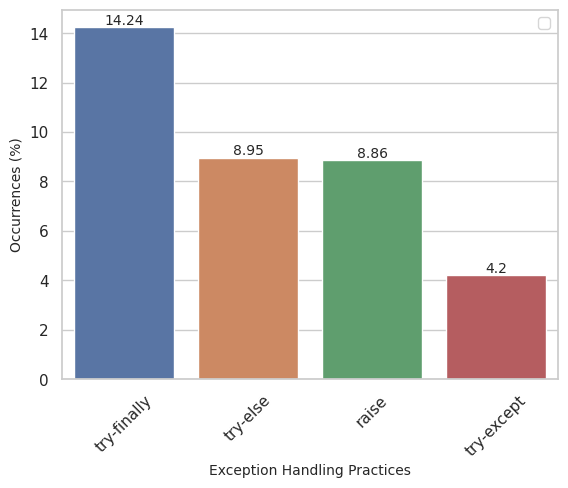

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total, x="Exception Handling", y="Percentage")
plt.ylabel("Occurrences (%)", fontsize= 10)
plt.xlabel("Exception Handling Practices", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)



In [35]:
df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()

In [36]:
df_except_types

,index,str_except_identifiers
0,Exception,2869
1,ValueError,1401
2,KeyError,986
3,AttributeError,755
4,DoesNotExist,617
...,...,...
1216,MultiplePublishersError,1
1217,PandaSpiNackResponse,1
1218,r_exception,1
1219,USBErrorTimeout,1


In [37]:
#df_except_types = df_except_types[1:]

In [38]:
def get_capitalized_elements(list):
    for element in list:
        if element[0].isupper():
            return element

In [39]:
#TODO: get a list of built-in exceptions and flag them
df_except_types['str_uniq_identifiers'] = df_except_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_except_types = df_except_types[df_except_types['str_uniq_identifiers'].notna()].head(20)

In [40]:
df_except_types = df_except_types.head(20) 
df_except_types['perc'] =  ((df_except_types['str_except_identifiers']/ df_except_types['str_except_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


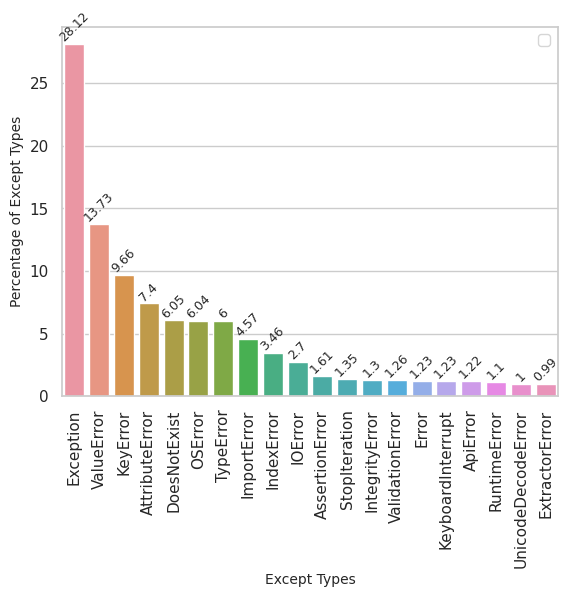

In [41]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_except_types, x="str_uniq_identifiers", y="perc")
plt.ylabel("Percentage of Except Types", fontsize= 10)
plt.xlabel("Except Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)


In [42]:
df_raise_types = df.str_raise_identifiers.str.split(" ").explode().value_counts().reset_index()
df_raise_types = df_raise_types[1:]
df_raise_types.head(20)

,index,str_raise_identifiers
1,NotImplementedError,4372
2,Exception,1201
3,TypeError,1018
4,RuntimeError,689
5,AnsibleError,503
6,ExtractorError,490
7,AssertionError,348
8,ValidationError,315
9,AttributeError,268
10,e,241


In [43]:
df_raise_types['str_uniq_identifiers'] = df_raise_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_raise_types = df_raise_types[df_raise_types['str_uniq_identifiers'].notna()].head(20)

In [44]:
df_raise_types = df_raise_types.head(20) 
df_raise_types['perc'] =  ((df_raise_types['str_raise_identifiers']/ df_raise_types['str_raise_identifiers'].sum()) * 100).round(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


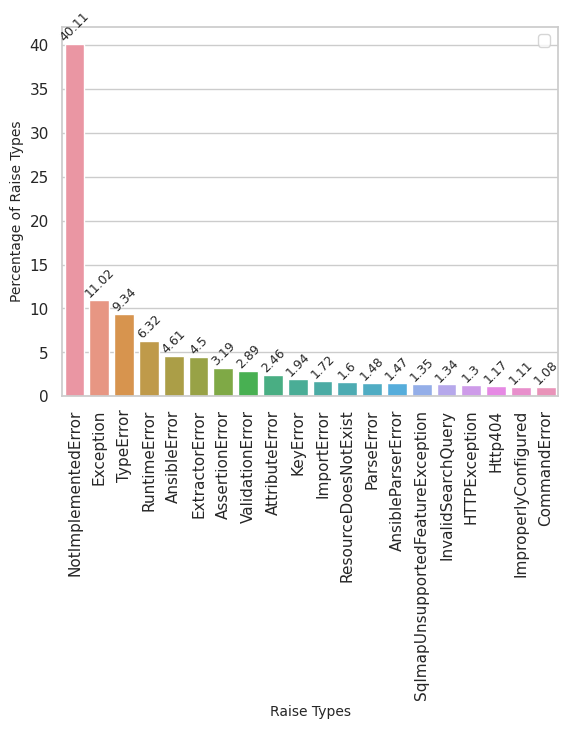

In [45]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_raise_types, x="index", y="perc")
plt.ylabel("Percentage of Raise Types", fontsize= 10)
plt.xlabel("Raise Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=9, rotation=45)

RQ2. 

In [46]:
df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.values

#df.str_uncaught_exceptions.str.split("[.][.][.]").values

array(['...build_tools.update_environments_and_lock_files.check_conda_lock_version:RuntimeError',
       '...build_tools.update_environments_and_lock_files.execute_command:RuntimeError',
       '...build_tools.update_environments_and_lock_files.execute_command:RuntimeError',
       ..., '...tests.tests_tqdm.squash_ctrlchars:ValueError',
       '...tests.tests_tqdm.squash_ctrlchars:ValueError',
       '...tests.tests_tqdm.pos_line_diff:AssertionError'], dtype=object)

In [47]:
import numpy as np
#Couting uncaught exceptions:
#df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.str.split("[.][.][.]").values[3]

df['n_uncaught_exceptions'] = df['str_uncaught_exceptions'].str.split("[.][.][.]").apply(lambda x: len(x)-1 if x is not np.nan else 0)

In [48]:
df.columns

Index(['file', 'function', 'func_body', 'n_try_except', 'n_try_pass',
       'n_finally', 'n_generic_except', 'n_raise', 'n_captures_broad_raise',
       'n_captures_try_except_raise', 'n_captures_misplaced_bare_raise',
       'n_try_else', 'n_try_return', 'str_except_identifiers',
       'str_raise_identifiers', 'str_except_block', 'str_uncaught_exceptions',
       'n_nested_try', 'n_bare_except', 'project', 'n_try_except_uni',
       'n_raise_uni', 'n_finally_uni', 'n_try_else_uni',
       'n_uncaught_exceptions'],
      dtype='object')

In [109]:
cols = ['n_captures_misplaced_bare_raise', 'n_generic_except', 'n_captures_broad_raise', 'n_try_pass', 'n_try_return', 'n_nested_try', 'n_uncaught_exceptions', 'n_try_except', 'n_raise']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [110]:
df.columns

Index(['file', 'function', 'func_body', 'n_try_except', 'n_try_pass',
       'n_finally', 'n_generic_except', 'n_raise', 'n_captures_broad_raise',
       'n_captures_try_except_raise', 'n_captures_misplaced_bare_raise',
       'n_try_else', 'n_try_return', 'str_except_identifiers',
       'str_raise_identifiers', 'str_except_block', 'str_uncaught_exceptions',
       'n_nested_try', 'n_bare_except', 'project', 'n_try_except_uni',
       'n_raise_uni', 'n_finally_uni', 'n_try_else_uni',
       'n_uncaught_exceptions', 'n_captures_misplaced_bare_raise_uni',
       'n_generic_except_uni', 'n_captures_broad_raise_uni', 'n_try_pass_uni',
       'n_try_return_uni', 'n_nested_try_uni', 'n_uncaught_exceptions_uni'],
      dtype='object')

In [113]:
df_rq2 = df.agg({'function': ['count'], 'n_captures_misplaced_bare_raise_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_try_pass_uni': ['sum'], 
                 'n_try_return_uni': ['sum'], 'n_nested_try_uni': ['sum'], 'n_uncaught_exceptions_uni': ['sum'], 'n_try_except_uni' : ['sum'], 'n_raise_uni' : ['sum']})
df_rq2 = df_rq2111.max().to_frame().T

In [114]:
df_rq2

,function,n_captures_misplaced_bare_raise_uni,n_generic_except_uni,n_captures_broad_raise_uni,n_try_pass_uni,n_try_return_uni,n_nested_try_uni,n_uncaught_exceptions_uni,n_try_except_uni,n_raise_uni
0,235863.0,41.0,2394.0,982.0,1499.0,2009.0,121.0,1834.0,9907.0,20909.0


In [118]:
#Trys
df_rq2['perc_n_try_pass_uni'] = (df_rq2['n_try_pass_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_generic_except_uni'] = (df_rq2['n_generic_except_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_uncaught_exceptions_uni'] = (df_rq2['n_uncaught_exceptions_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_try_return_uni'] = (df_rq2['n_try_return_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_nested_try_uni'] = (df_rq2['n_nested_try_uni']/ df_rq2['n_try_except_uni']) * 100

#Raise
df_rq2['perc_n_captures_misplaced_bare_raise_uni'] = (df_rq2['n_captures_misplaced_bare_raise_uni']/ df_rq2['n_raise_uni']) * 100
df_rq2['perc_n_captures_broad_raise_uni'] = (df_rq2['n_captures_broad_raise_uni']/ df_rq2['n_raise_uni']) * 100

df_rq2

,function,n_captures_misplaced_bare_raise_uni,n_generic_except_uni,n_captures_broad_raise_uni,n_try_pass_uni,n_try_return_uni,n_nested_try_uni,n_uncaught_exceptions_uni,n_try_except_uni,n_raise_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni,perc_n_nested_try_uni
0,235863.0,41.0,2394.0,982.0,1499.0,2009.0,121.0,1834.0,9907.0,20909.0,15.130716,24.164732,18.512163,20.278591,0.196088,4.696542,1.221359


In [119]:
df_total_rq2 = df_rq2.loc[:, ["perc_n_nested_try_uni", "perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_uncaught_exceptions_uni", "perc_n_try_return_uni", "perc_n_captures_misplaced_bare_raise_uni", "perc_n_captures_broad_raise_uni"]]
df_total_rq2

,perc_n_nested_try_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni
0,1.221359,15.130716,24.164732,18.512163,20.278591,0.196088,4.696542


In [120]:
df_total_rq2.columns = ['Nested Try', 'Swallowing Exceptions', 'Too Broad Except', 'Uncaught Exceptions', 'Try and Return', 'Bare Raise Block', 'Too Broad Raising']
df_total_rq2

,Nested Try,Swallowing Exceptions,Too Broad Except,Uncaught Exceptions,Try and Return,Bare Raise Block,Too Broad Raising
0,1.221359,15.130716,24.164732,18.512163,20.278591,0.196088,4.696542


In [121]:
df_total_rq2 = df_total_rq2.T[0:].reset_index()
df_total_rq2

,index,0
0,Nested Try,1.221359
1,Swallowing Exceptions,15.130716
2,Too Broad Except,24.164732
3,Uncaught Exceptions,18.512163
4,Try and Return,20.278591
5,Bare Raise Block,0.196088
6,Too Broad Raising,4.696542


In [122]:
#rename columns:
df_total_rq2.columns = ['Exception Handling', 'Percentage']
df_total_rq2['Percentage'] = df_total_rq2['Percentage'].round(2)

#order by percentage:
df_total_rq2 = df_total_rq2.sort_values(by=['Percentage'], ascending=False)
df_total_rq2

,Exception Handling,Percentage
2,Too Broad Except,24.16
4,Try and Return,20.28
3,Uncaught Exceptions,18.51
1,Swallowing Exceptions,15.13
6,Too Broad Raising,4.70
0,Nested Try,1.22
5,Bare Raise Block,0.20


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


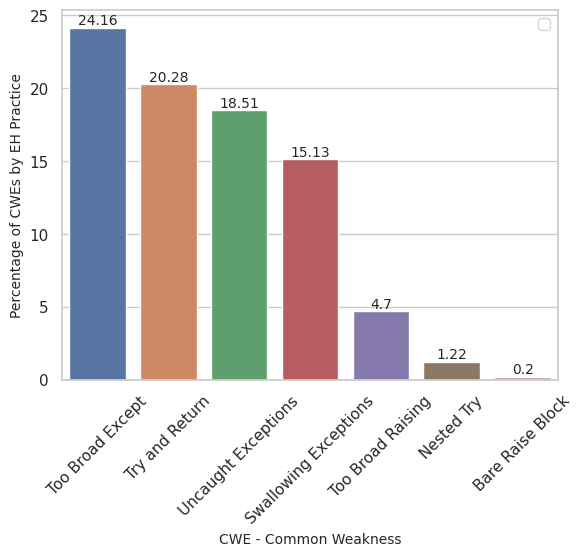

In [123]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total_rq2, x="Exception Handling", y="Percentage")
plt.ylabel("Percentage of CWEs by EH Practice", fontsize= 10)
plt.xlabel("CWE - Common Weakness", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

RQs New

In [130]:
df_rq21 = df.groupby('project').agg({'function': ['count'], 'n_captures_misplaced_bare_raise_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_try_pass_uni': ['sum'], 
                                    'n_try_return_uni': ['sum'], 'n_nested_try_uni': ['sum'], 'n_uncaught_exceptions_uni': ['sum'],
                                    'n_try_except_uni' : ['sum'], 'n_raise_uni' : ['sum']}).reset_index()
#df_rq2 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']})
#df_rq2 = df_rq2.max().to_frame().T

In [131]:
#Trys
df_rq21['perc_n_try_pass_uni'] = (df_rq21['n_try_pass_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_n_generic_except_uni'] = (df_rq21['n_generic_except_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_uncaught_exceptions_uni'] = (df_rq21['n_uncaught_exceptions_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_n_try_return_uni'] = (df_rq21['n_try_return_uni']/ df_rq21['n_try_except_uni']) * 100
df_rq21['perc_n_nested_try_uni'] = (df_rq21['n_nested_try_uni']/ df_rq21['n_try_except_uni']) * 100

#Raise
df_rq21['perc_n_captures_misplaced_bare_raise_uni'] = (df_rq21['n_captures_misplaced_bare_raise_uni']/ df_rq21['n_raise_uni']) * 100
df_rq21['perc_n_captures_broad_raise_uni'] = (df_rq21['n_captures_broad_raise_uni']/ df_rq21['n_raise_uni']) * 100

df_rq21

,project,function,n_captures_misplaced_bare_raise_uni,n_generic_except_uni,n_captures_broad_raise_uni,n_try_pass_uni,n_try_return_uni,n_nested_try_uni,n_uncaught_exceptions_uni,n_try_except_uni,n_raise_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_nested_try_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni
,,count,sum,sum,sum,sum,sum,sum,sum,sum,sum,,,,,,,
0,12306,175,0,10,1,3,1,0,0,21,10,14.285714,47.619048,0.000000,4.761905,0.000000,0.000000,10.000000
1,ailearning,924,0,0,0,0,0,0,0,8,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,algo,46,0,5,0,0,6,0,0,12,0,0.000000,41.666667,0.000000,50.000000,0.000000,NaN,NaN
3,ansible,9734,0,361,138,215,200,33,228,1176,1282,18.282313,30.697279,19.387755,17.006803,2.806122,0.000000,10.764431
4,awesome-python,2,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,xx-net,5122,0,229,52,73,166,7,76,573,874,12.739965,39.965096,13.263525,28.970332,1.221640,0.000000,5.949657
61,yolov5,604,0,35,5,2,17,1,15,47,19,4.255319,74.468085,31.914894,36.170213,2.127660,0.000000,26.315789
62,you-get,665,5,5,14,17,7,2,24,68,58,25.000000,7.352941,35.294118,10.294118,2.941176,8.620690,24.137931


In [154]:
df_total_rq21 = df_rq21.loc[:, ["project", "function", "perc_n_nested_try_uni", "perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_uncaught_exceptions_uni", "perc_n_try_return_uni", "perc_n_captures_misplaced_bare_raise_uni", "perc_n_captures_broad_raise_uni"]]
df_total_rq21

,project,function,perc_n_nested_try_uni,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions_uni,perc_n_try_return_uni,perc_n_captures_misplaced_bare_raise_uni,perc_n_captures_broad_raise_uni
,,count,,,,,,,
0,12306,175,0.000000,14.285714,47.619048,0.000000,4.761905,0.000000,10.000000
1,ailearning,924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,algo,46,0.000000,0.000000,41.666667,0.000000,50.000000,NaN,NaN
3,ansible,9734,2.806122,18.282313,30.697279,19.387755,17.006803,0.000000,10.764431
4,awesome-python,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
60,xx-net,5122,1.221640,12.739965,39.965096,13.263525,28.970332,0.000000,5.949657
61,yolov5,604,2.127660,4.255319,74.468085,31.914894,36.170213,0.000000,26.315789
62,you-get,665,2.941176,25.000000,7.352941,35.294118,10.294118,8.620690,24.137931


In [150]:
#rename columns:
#df_total_rq21.columns = ['Exception Handling', 'Percentage']
#df_total_rq21['Percentage'] = df_total_rq21['Percentage'].round(2)

#order by percentage:
#df_total_rq21 = df_total_rq21.sort_values(by=['Percentage'], ascending=False)
#df_total_rq21

In [153]:
df_total_rq21

,Nested Try,Swallowing Exceptions,Too Broad Except,Uncaught Exceptions,Try and Return,Bare Raise Block,Too Broad Raising
0,0.000000,14.285714,47.619048,0.000000,4.761905,0.000000,10.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,41.666667,0.000000,50.000000,NaN,NaN
3,2.806122,18.282313,30.697279,19.387755,17.006803,0.000000,10.764431
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
60,1.221640,12.739965,39.965096,13.263525,28.970332,0.000000,5.949657
61,2.127660,4.255319,74.468085,31.914894,36.170213,0.000000,26.315789
62,2.941176,25.000000,7.352941,35.294118,10.294118,8.620690,24.137931
63,0.168067,24.369748,11.764706,20.336134,26.050420,0.000000,2.052239


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


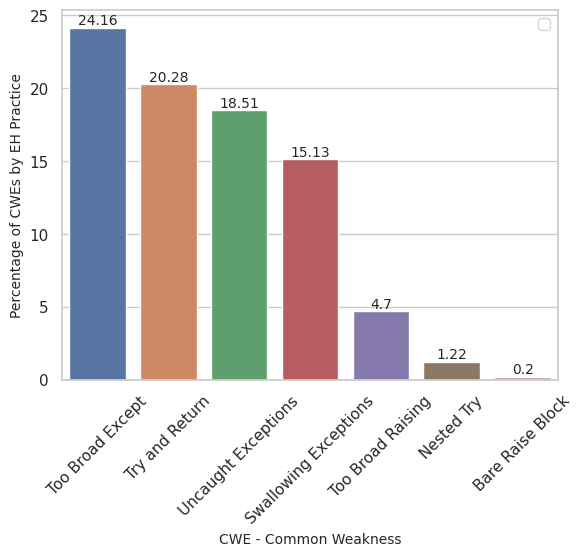

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig = sns.violinplot(x='rule', y='commit', orient= 'v', cut=0, scale='width', data=df_com_adj).get_figure()
plt.ylabel("Number of Commits", fontsize= 10)
plt.xlabel("Exception Handling Smell", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)